MONGODB: AirQuality in Nairobi

In [1]:
# imports
import pandas as pd
from pprint import PrettyPrinter
from pymongo import MongoClient

import pytz
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# instantiate PrettyPrinter
pp = PrettyPrinter(indent=2)
# Connect to Db
client = MongoClient(host="localhost", port=27017)
# Assign air-quality database to db
db = client["airquality"]
# Assign Nairobi collection to nairobi
nairobi = db["Nairobi"]

In [3]:
def dataWrangle(collection, resample_rule="5Min"):
    """Query db collection and return df"""
    result = collection.find({"location": 3573, "value_type": "P2"},
                     projection={
                         "timestamp": 1,
                         "value": 1,
                         "_id": 0})

    # Read result into df
    df = pd.DataFrame(result)

    # Convert timestamp to datetime object and to Nairobi time
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.set_index("timestamp")
    df.index = df.index.tz_convert('Africa/Nairobi')

    # Rename value to P2
    df = df.rename(columns={"value":"P2"})

    # Remove outliers: P2 readings > 500 are not true measure of PM
    df = df[df["P2"] < 35]

    # # Resample to take readings, forward fill missing values
    y = df["P2"].resample(resample_rule).mean().ffill()

    # # # Feature engineering: creating a lag of 1
    # df["P2.T-1"] = df["P2"].shift(1)

    # # # Drop Nans
    # df.dropna(inplace=True)

    return y

In [4]:
y = dataWrangle(nairobi)
print(len(y))
y.head()

1818


timestamp
2023-11-01 03:00:00+03:00    16.325000
2023-11-01 03:05:00+03:00    12.062500
2023-11-01 03:10:00+03:00    15.311111
2023-11-01 03:15:00+03:00    11.555000
2023-11-01 03:20:00+03:00     9.283333
Freq: 5T, Name: P2, dtype: float64

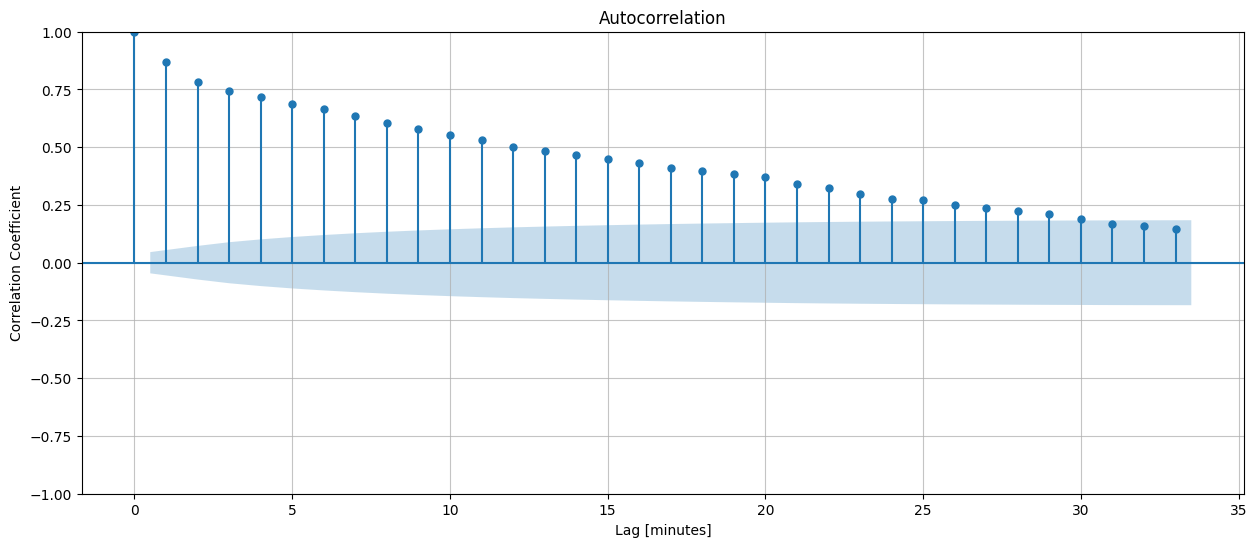

In [5]:
# P2 readings boxplot --> Checking for outliers --> Boxplot (plt)
# ACF plot: shows predictive power of previous time steps
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [minutes]")
plt.ylabel("Correlation Coefficient")
plt.grid(axis="y", alpha=0.75)
plt.grid(axis="x", alpha=0.75);

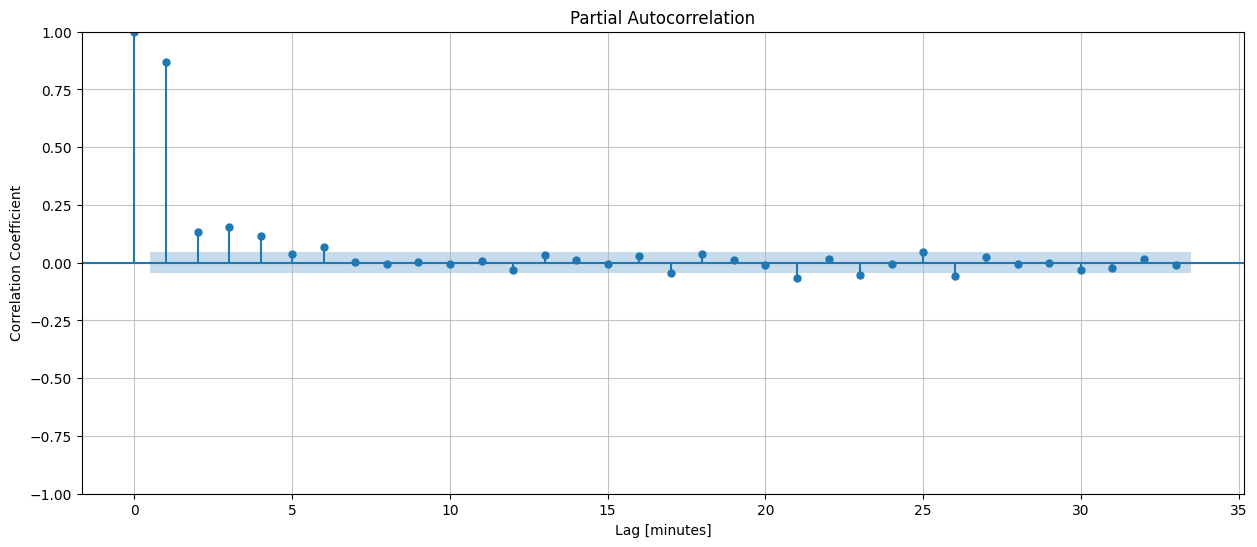

In [6]:
# Time series plot for P2 readings --> line plot (pandas)

# PACF plot: how many lags to include in the model
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [minutes]")
plt.ylabel("Correlation Coefficient")
plt.grid(axis="y", alpha=0.75)
plt.grid(axis="x", alpha=0.75);

In [7]:
# Plot rolling average to smoothen ot the peaks and valleys (pandas)
# Calculate rolling avgs --> no. of hrs in 2 days

In [8]:
# Scatter plot (plt)

In [9]:
# Split: feature and target --> vertical split
# Split: training [90%] and test[10%] --> cutoff split --> horizontal split
# Split y: 95%: 5%
# cutoff = int(len(y) * 0.95)

# Split: horizontal split
y_train = y.loc["2023-11-01":"2023-11-06"]
y_test = y.loc["2023-11-07"]
# len(y_test) + len(y_train) == len(y)

In [10]:
# Baseline
y_pred_baseline = [y_train.mean()] * len(y_train)
mae_baseline = mean_absolute_error(y_pred_baseline, y_train)
round(mae_baseline, 2)

5.08

In [11]:
# Buid model
# model = AutoReg(y_train, lags=34).fit()

# ARMA model --> AutoRegressive Moving Average : prevent exogenous shocks echos
# Hyperparameter tuning: determine the possible values of p and q
p_params = range(0, 33, 10)  # check PACF plot
q_params = range(0, 4)  # check ACF plot

In [12]:
import warnings
warnings.filterwarnings("ignore")

for p in p_params:
    for q in q_params:
        order = (p, 0, q)
        # Model training
        model = ARIMA(y_train, order=order).fit()
        print(f"Trained ARIMA model {order}")
        # Generate predictions
        y_pred = model.predict()
        # Calculate training mae
        mae_train = mean_absolute_error(y_pred, y_train)
        print(mae_train)

warnings.filterwarnings("default")

Trained ARIMA model (0, 0, 0)
5.075705288186986
Trained ARIMA model (0, 0, 1)
3.6153649752035113
Trained ARIMA model (0, 0, 2)
3.0846205467669106
Trained ARIMA model (0, 0, 3)
2.8771458197620956
Trained ARIMA model (10, 0, 0)
2.221727952632571
Trained ARIMA model (10, 0, 1)
2.2209395738698117
Trained ARIMA model (10, 0, 2)
2.221416029827835
Trained ARIMA model (10, 0, 3)
2.2220868706931145
Trained ARIMA model (20, 0, 0)
2.2144119969283875
Trained ARIMA model (20, 0, 1)
2.217715614136529
Trained ARIMA model (20, 0, 2)
2.2156309750620817
Trained ARIMA model (20, 0, 3)
2.220799147769136
Trained ARIMA model (30, 0, 0)
2.2105345659729467
Trained ARIMA model (30, 0, 1)
2.219590629330891
Trained ARIMA model (30, 0, 2)
2.2111213955788207
Trained ARIMA model (30, 0, 3)
2.209895427713235


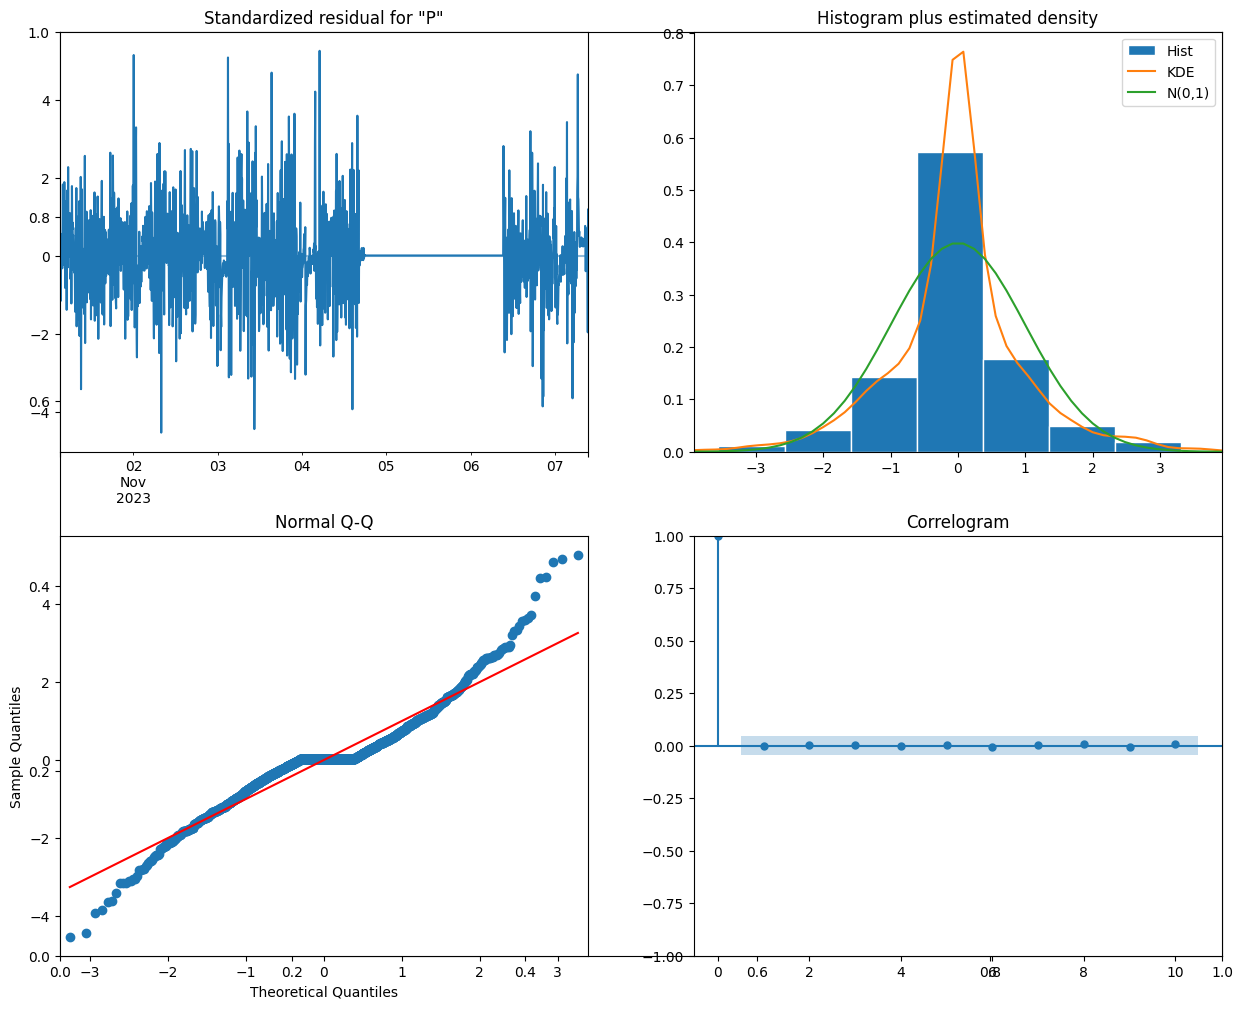

In [15]:
# Model diagnostics
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig=fig);

In [17]:
# Evaluate
import warnings
warnings.filterwarnings("ignore")


y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = ARIMA(history, order=(0, 0, 3)).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv._append(next_pred)
    history = history._append(y_test[next_pred.index])

In [18]:
test_mae = mean_absolute_error(y_pred_wfv, y_test)
print(f"Test MAE wfv: {test_mae}")

Test MAE wfv: 4.569024950007676


In [21]:
# Communicate
df_pred_test = pd.DataFrame({
    "y_test": y_test,
    "y_pred_wfv":y_pred_wfv}).set_index(y_test.index)

df_pred_test.head()

,y_test,y_pred_wfv
timestamp,,
2023-11-07 00:00:00+03:00,18.587500,22.277677
2023-11-07 00:05:00+03:00,15.612500,17.489258
2023-11-07 00:10:00+03:00,11.266667,15.538229
2023-11-07 00:15:00+03:00,11.237500,11.687116
2023-11-07 00:20:00+03:00,15.338889,14.025502


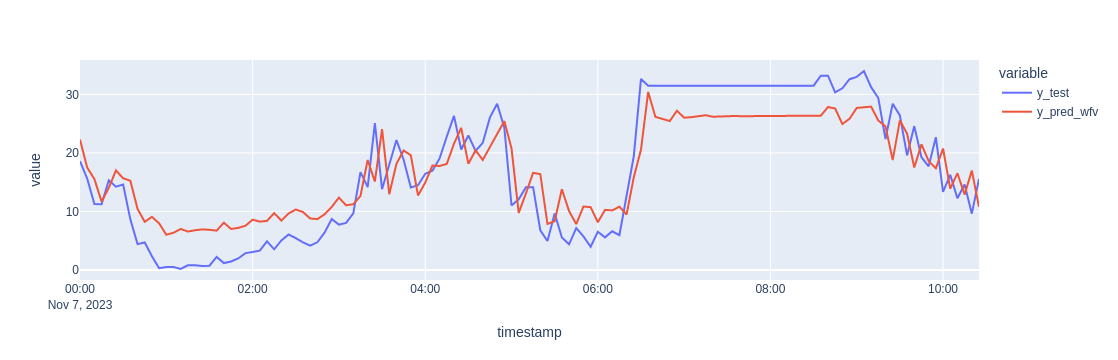

In [22]:
fig = px.line(df_pred_test, labels={"values": "P2"})
fig.show()